# P1: Solve the OpenAI Gym [Taxi V3](https://gym.openai.com/envs/Taxi-v3/) Environment
---

## Introduction
[OpenAI Gym](https://gym.openai.com/docs/) is a framework that provides RL environments of varying complexity with the same standard API making it easy to develop and benchmark RL algorithms. The [Taxi-V3](https://gym.openai.com/envs/Taxi-v3/) environmnet present a simple, text environment where actions and state (observations) are both discrete. 

In [50]:
import gym

The `gym.make()` API can be used to spawn any of the available environments by passing its full name.

In [51]:
taxi = gym.make('Taxi-v3')

The Taxi environment has 500 states and 6 possible actions.

In [52]:
taxi.action_space

Discrete(6)

In [53]:
taxi.observation_space

Discrete(500)

The task and reward structure are described in the [documentation](https://github.com/openai/gym/blob/a5a6ae6bc0a5cfc0ff1ce9be723d59593c165022/gym/envs/toy_text/taxi.py#L25)

In [54]:
taxi.reset()
taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Submission
- Submit your solution as a Jupyter notebook. 
- Ensure that all cells in the notebook have been executed and the output is showing
- Ensure that your solution consistently reaches the average cumulative reward defined in the rubric (link below)
- Post your solution on Github and share the link to your commit as a direct message in Slack

## Evaluation
The goal of the project is to get a certain average (cumulative) reward over 100 episodes. To pass the project, you must meet all the requirments in the project [rubric](https://github.com/KnowchowHQ/rl-in-action/blob/master/C1-RL-Intro/W3OH/P1-rubric.md)

# Part 1

The methods are as follows:
* `seed()`: generate a seeded random number generator.
* `reset()`: reset the environment (randomly select new starting state and reset `lastaction` variable
* `step(action)`: take a step with an action to advance the state

Variables:
* `isd`: distribution modelling the probabilities of a certain initial state
* `lastaction`: the previous executed action
* `nS`: Number of states
* `nA`: Number of actions
* `action_space`: object with all possible actions
* `observation_space`: object with all possible states
* `s`: current state

# Part 2

Methods:
* `encode(row, col, pass_loc, dest_idx)`: Convert the 4-tuple state into a single integer
* `decode(i)`: Convert a state integer into a 4-tuple
* `render()`: Render the state by printing it out

Variables:
* `locs`: locations of possible pickup and drop off places
* `num_states`: number of states
* `num_rows, num_columns`: dimensions of the board
* `max_row, max_col`: max index of each dimension
* `initial_state_distrib`: like isd above
* `num_actions`: number of actions

# Part 3

The environment is a 5x5 grid of locations the taxi can occupy. 4 of these locations are possible pickup and dropoff locations (labeled R, G, B, and Y). The passenger can exist at any one of these 4 locations or in the taxi.

The taxi has 6 actions
* Move in a cardinal direction
* Pick up the passenger
* Drop off the passenger

The state contains all necessary information. That is, the posiiton of the taxi, the location of the passenger in one of its valid positions (R, G, B, Y, taxi), and the destination (R, G, B or Y)

The rewards are as follows
* Each step is -1, to encourage short trips
* A valid drop off is +20, to encourage the agent to make the drop off
* An invalid pickup or drop off is -10, to discourage misused pickup and drop off actions.

In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [98]:
def epsilon_greedy_action_from_Q(Q, state, epsilon):
  actions = Q.columns
  greedy_action = np.argmax(Q.loc[state].values)

  action_probs = np.asarray([epsilon/len(actions)]*len(actions), dtype=np.float)
  action_probs[greedy_action] += 1 - epsilon

  epsilon_greedy_choice = np.random.choice(Q.columns, p=action_probs)

  return epsilon_greedy_choice

def run_sarsa(hyper_params):
  Q = pd.DataFrame.from_dict({s:{a: 0 for a in range(taxi.action_space.n)} for s in range(taxi.observation_space.n)}, orient="index")

  epsilon = hyper_params["epsilon_init"]
  rewards = np.zeros(hyper_params["num_episodes"])
  illegal_action_episodes = set()

  for ep_num in tqdm(range(hyper_params["num_episodes"]), position=0, leave=True):
    s0 = taxi.reset()
    a0 = epsilon_greedy_action_from_Q(Q, s0, epsilon)
    done = False

    episode_reward = 0
    while True:
      if done:
        break

      s1, reward, done, _ = taxi.step(a0)
      a1 = epsilon_greedy_action_from_Q(Q, s1, epsilon)

      Q.loc[s0, a0] += \
      hyper_params["alpha"]*(reward + hyper_params["gamma"]*Q.loc[s1, a1] - Q.loc[s0, a0])

      s0, a0 = s1, a1
      episode_reward += reward

      if ep_num >= hyper_params["num_episodes"] - 1000 and reward == -10:
        illegal_action_episodes.add(ep_num)

    rewards[ep_num] = episode_reward
    if ep_num > hyper_params["epsilon_decay_delay"]:
      epsilon = max(epsilon*hyper_params["epsilon_decay"], hyper_params["epsilon_min"])
  
  print("Illegal pickups/dropoffs occurred in " + str(len(illegal_action_episodes)) + " of the last 1000 episodes")
  return Q, rewards

def read_rewards(rewards):
  windowed_rewards = np.convolve(rewards, np.ones(100)/100, 'valid')
  last_1000 = windowed_rewards[-900:]
  
  print()
  print("50th percentile: " + str(np.percentile(last_1000, 50)))
  print("95th percentile: " + str(np.percentile(last_1000, 95)))

  plt.plot(windowed_rewards)
  plt.xlabel("episode")
  plt.ylabel("reward")
  plt.show()

def display_episode(Q):
  for _ in range(50):
    s = taxi.reset()
    a = epsilon_greedy_action_from_Q(Q, s, 0)
    s, _, done, _ = taxi.step(a)

    taxi.render()

    if done:
      break

# Parts 4, 5, and 6

My results for various sets of hyper parameters can be seen in the table below. To test them for yourself, you can call `run_sarsa(h)` where `h` is one of the hyper params dicts defined in the cell below.

| hyper_parameter_set | 50th percentile | 95th percentile |
|---------------------|-----------------|-----------------|
| `hyper_params_1`    | -5.2            | -2.7            |
| `hyper_params_2`    | 5.19            | 6.31            |
| `hyper_params_3`    | 8.06            | 8.42            |

My fixed hyper parameter choices

1. `num_episodes`: Will be no greater than 10000 for the sake of time efficiency
2. `epsilon_init`: Will be set to 1 initially, for completely random episodes at the beginning of SARSA. Will not change.
3. maximum episode length: There is no max episode length as I want the reward for a successful dropoff factored in at each episode 

I decided to start at the following hyper params for my first test (which can be found in `hyper_params_1`)

1. `num_episodes`: 10000, my max, to check if the algorithm will converge
2. `epsilon_min`: 0.05, since we want it to decay to almost nothing so as to not explore on the final 1000 episodes
3. `epsilon_decay_delay`: 500, to allow for many initial episodes of pure explorations 
4. `alpha`: 0.01, to make small changes
5. `gamma`: 0.99, to moderately discount future returns

The results weren't good and my graph of windowed rewards over time didn't show convergence so I decided to make the following changes (found in `hyper_params_2`)

1. `alpha`: increased to 0.04. More aggressive changes will be needed for faster convergence. 
2. `epsilon_decay_delay`: The epochs at the beginning with random exploration seemed to merely delay the start of useful training so I decided to reduce the number of epochs pure exploration epochs to 100.

Results improved greatly and the graph converged in 10000 episodes. Though I suspected improved training would come from not discounting further rewards so much. So I made the following changes (found in `hyper_params_3`).

1. `gamma`: increased gamma to 0.999, therefore policies that direct towards a correct dropoff would more prominantly emphasize the reward of a correct dropoff
2. `epislon_min`: set to 0 since we want virtually no exploration in the final episodes, so as to boost the windowed returns that will be used for results.

And as you can see from the table, the 50th precentile and 95th precentile were in range. As well, no illegal dropoffs or pickups were performed in the last 1000 episodes.

100%|██████████| 10000/10000 [03:03<00:00, 54.40it/s]


Illegal pickups/dropoffs occurred in 0 of the last 1000 episodes

50th percentile: 8.06
95th percentile: 8.42


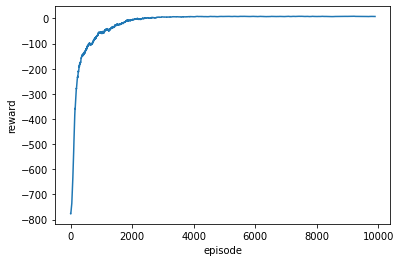

In [99]:
hyper_params_1 = {
    "num_episodes": 10000,
    "epsilon_init": 1,
    "epsilon_decay": 0.99,
    "epsilon_decay_delay": 500,
    "epsilon_min": 0.05,
    "alpha": 0.01,
    "gamma": 0.99
}

hyper_params_2 = {
    "num_episodes": 10000,
    "epsilon_init": 1,
    "epsilon_decay": 0.99,
    "epsilon_decay_delay": 100,
    "epsilon_min": 0.05,
    "alpha": 0.04,
    "gamma": 0.99
}

hyper_params_3 = {
    "num_episodes": 10000,
    "epsilon_init": 1,
    "epsilon_decay": 0.99,
    "epsilon_decay_delay": 100,
    "epsilon_min": 0.00,
    "alpha": 0.04,
    "gamma": 0.999
}

Q_final, rewards = run_sarsa(hyper_params_3)
read_rewards(rewards)